In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from sklearn.externals import joblib

from scipy.optimize import curve_fit

In [2]:
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=30)
plt.rc('figure', figsize=(15, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 

In [3]:
def plot_pulls(pull):
    pull = np.swapaxes(pull, 0, 1)
    fig, ax = plt.subplots(4, 3, figsize=(10, 15), sharex=True)
    pull_bins = np.linspace(-3.0, 3.0, 20)
    t = np.linspace(-3.0, 3.0, 100)
    # y_gauss = np.exp(-t ** 2 / 2.0) / np.sqrt(2.0 * np.pi)
    for i in range(nbins_E + 2):
        idx_1, idx_2 = np.unravel_index(i, ax.shape)
        p_stat = ((pull[0] - pull[1]) / pull[2])[:,i]
        p_stat = np.array(filter(lambda x : np.abs(x) < 10, p_stat))
        ax[idx_1, idx_2].hist(p_stat, pull_bins, normed=True)
        y_gauss = np.exp(-(t - np.mean(p_stat)) ** 2 / (2.0 * np.var(p_stat))) / np.sqrt(2.0 * np.pi * np.var(p_stat))
        ax[idx_1, idx_2].plot(t, y_gauss)
        ax[idx_1, idx_2].set_xlim([-3.0, 3.0])
        leg = ax[idx_1, idx_2].legend([], loc="upper right")
        leg.set_title("Bin %i\nMean %.2f\nStd: %.2f" % (i, np.mean(p_stat), np.std(p_stat)),prop={'size':25})
    for i in range(ax.shape[1]):
        ax[-1, i].set_xlabel("Pull Statistic")
    # fig.delaxes(ax[-1,-1])
    plt.tight_layout()
    plt.show()

In [4]:
def plot_bias(pull_results):
    fig, ax = plt.subplots(2, len(reg_coeff_list)/2, figsize=(16, 7), sharex=True, sharey=True)
    for i, tau in enumerate(reg_coeff_list):
        pull = pull_results[i]
        pull = np.swapaxes(pull, 0, 1)
        idx_1, idx_2 = np.unravel_index(i, ax.shape)
        data_list = []
        for j in range(nbins_E + 2):
            p_stat = ((pull[0] - pull[1]) / pull[2])[:,j]
            p_stat = np.array(filter(lambda x : np.abs(x) < 10, p_stat))
            data_list.append([j, np.mean(p_stat), np.std(p_stat)])
        data_list = np.array(data_list)
        ax[idx_1, idx_2].errorbar(x=data_list[:,0], y=data_list[:,1], yerr=data_list[:,2], fmt='x', label=r'$\tau = %f$' % tau, capsize=4, color='green')
        ax[idx_1, idx_2].hlines(y=[-1, 1], xmin=0, xmax=11, linestyles='--', color='red')
        ax[idx_1, idx_2].xlim = (-1, 22)
        ax[idx_1, idx_2].legend(loc="upper right", fontsize=20)  
        if idx_2 == 0:
            ax[idx_1, idx_2].set_ylabel('pull statistic mean')
        if idx_1 == ax.shape[0] - 1:
            ax[idx_1, idx_2].set_xlabel('bin')
    plt.show()

In [5]:
def plot_eventSpectrum(data):
    data = np.swapaxes(data, 0, 1)
    
    
    plt.figure(figsize=(16, 7))
    plt.fill_between(np.arange(nbins_E + 2), np.percentile(data[1], 15, axis=0),
                     np.percentile(data[1], 85, axis=0), step='mid', alpha=0.2)
    plt.plot(np.arange(nbins_E + 2), np.median(data[1], axis=0), drawstyle='steps-mid', label='Unfolding')
    plt.plot(np.arange(nbins_E + 2), np.median(data[0], axis=0), drawstyle='steps-mid', label='True Stopping')
    plt.plot(np.arange(nbins_E + 2), true_data, drawstyle='steps-mid', label='True')
    plt.yscale('log')
    plt.xlim([0, nbins_E + 1])
    plt.xlabel(r'energy bin index')
    plt.ylabel(r'event rate / $s^{-1}$')
    plt.legend(loc='best', fontsize=25)
    plt.show()

In [6]:
def plot_flux(data, fit=False):
    data = np.swapaxes(data, 0, 1)
    
    data = np.array(data)[: , : , 1:-1]
    
    X = np.logspace(np.log10(eMin), np.log10(eMax), num=nbins_E)
    
    plt.figure(figsize=(16, 7))
    plt.fill_between(X, X**3 * np.percentile(data[1], 15, axis=0) / acceptance[1:-1], X**3 * np.percentile(data[1], 85, axis=0) / acceptance[1:-1], step='mid', alpha=0.2)
    plt.plot(X, X**3 * np.median(data[1], axis=0) / acceptance[1:-1], drawstyle='steps-mid', label='Unfolded Spectrum')
    plt.plot(X, X**3 * true_data[1:-1] / acceptance_nonestop[1:-1] /nbins_E , drawstyle='steps-mid', label='True Spectrum')
    # plt.plot(np.logspace(np.log10(eMin), np.log10(eMax), num=nbins_E), np.median(data[0], axis=0) / acceptance[1:-1], drawstyle='steps-mid', label='True Stopping Spectrum')
    
    if fit == True:
        results = np.median(data[1], axis=0) / acceptance[1:-1]
        
        results = results[2:]
        
        # def pot_law(x,a,b,c):
            # return a + b * np.power(x,c)
            
        def lin_law(x,a,b):
            return a + b * x
        
        x = np.log10(np.logspace(np.log10(eMin), np.log10(eMax), num=nbins_E))[2:]
        y = np.log10(results)
        fit_params = np.polyfit(x, y, deg=1, cov=True)
        # fit_params = curve_fit(pot_law, np.logspace(np.log10(eMin), np.log10(eMax), num=nbins_E)[2:], results, p0=[1,1,-3.7])  
        print fit_params
        loc = np.logspace(np.log10(eMin), np.log10(eMax), num=nbins_E)[2:]
        values = np.power(10, lin_law(np.log10(loc),fit_params[0][1],fit_params[0][0]))
        # plt.plot(loc, values, label='fit')
        # plt.plot(loc, pot_law(loc,fit_params[0][0],fit_params[0][1],fit_params[0][2]), label='fit')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$E_{\mu} / GeV$')
    plt.ylabel(r'$\frac{\mathrm{d} \Phi}{\mathrm{d} E} / (GeV \, m^2 \, sr \, s)^{-1}$')
    plt.xlim([eMin, eMax])
    plt.legend(loc='best', fontsize=25)
    plt.show()

In [7]:
data_dir = '/home/sninfa/jupyter/data/400-30k_10Bins'

input_df = joblib.load('%s/df_corsica_est.pickle' % data_dir)
area = joblib.load('%s/effArea_mgs_corsica_total.pickle' % data_dir)
area_nonestop = joblib.load('%s/effArea_mgs_corsica_nonstop_total.pickle' % data_dir)

In [8]:
r_gen = 800
h_gen = 1600
A_gen = 2 * np.pi * r_gen * h_gen + 2 * np.pi * r_gen**2

eMin = 400
eMax = 30000

nbins_E = 10
nbins_r = 10

binning_E = np.logspace(np.log10(eMin), np.log10(eMax), nbins_E + 1)
bin_width = [binning_E[i+1] - binning_E[i] for i in range(nbins_E)]

binning_idx_E = np.arange(nbins_E + 3) - 0.5

acceptance = np.multiply(area.values.transpose()[0], np.array(bin_width)) * (2 * np.pi * (1 - np.cos(77 / 180 * np.pi)))
acceptance = np.insert(acceptance, 0 , acceptance[0])
acceptance = np.append(acceptance, acceptance[-1])

acceptance_nonestop = np.multiply(area_nonestop.values.transpose()[0], np.array(bin_width)) * (2 * np.pi * (1 - np.cos(77 / 180 * np.pi)))
acceptance_nonestop = np.insert(acceptance_nonestop, 0 , acceptance[0])
acceptance_nonestop = np.append(acceptance_nonestop, acceptance[-1])

range_correction = pd.read_csv('/home/sninfa/jupyter/data/penetration_correction.csv')

# acceptance[1:-1] *= range_correction.coeff
# acceptance_nonestop[1:-1] *= range_correction.coeff

In [9]:
acceptance

array([   55420.99454411,    55420.99454411,    72734.86523631,
         101184.29756674,   185656.34895085,   584138.2900704 ,
        1941899.48030259,  4427290.38304897,  7815353.26526438,
       13591051.21933602, 21699062.47105324, 21699062.47105324])

In [10]:
acceptance_nonestop

array([5.54209945e+04, 8.09175290e+05, 8.42737582e+05, 1.65355216e+06,
       6.15581662e+06, 2.74033571e+07, 8.84392179e+07, 1.88900000e+08,
       3.23401007e+08, 5.32111447e+08, 8.14110846e+08, 2.16990625e+07])

In [11]:
input_df['energy_idx'] = np.digitize(input_df.energy_stop, binning_E)
    
true_data, _ = np.histogram(input_df.energy_idx, binning_idx_E)
# true_data, _ = np.histogram(input_df.energy_idx, binning_idx_E, weights=input_df.weight)

In [12]:
reg_coeff_list = [0.01,0.1,1,10,100,1000]
# reg_coeff_list = [0.01,0.1,1,10,50,100,250,1000]

In [13]:
# set1 = joblib.load('/home/sninfa/jupyter/data/unfolding_v4_G3_output.pickle')
set1 = joblib.load('/home/sninfa/jupyter/data/unfolding_v4_G3_output_weighted.pickle')
set2 = joblib.load('/home/sninfa/jupyter/data/unfolding_v4_G4_output.pickle')
set3 = joblib.load('/home/sninfa/jupyter/data/unfolding_v4_H4_output.pickle')

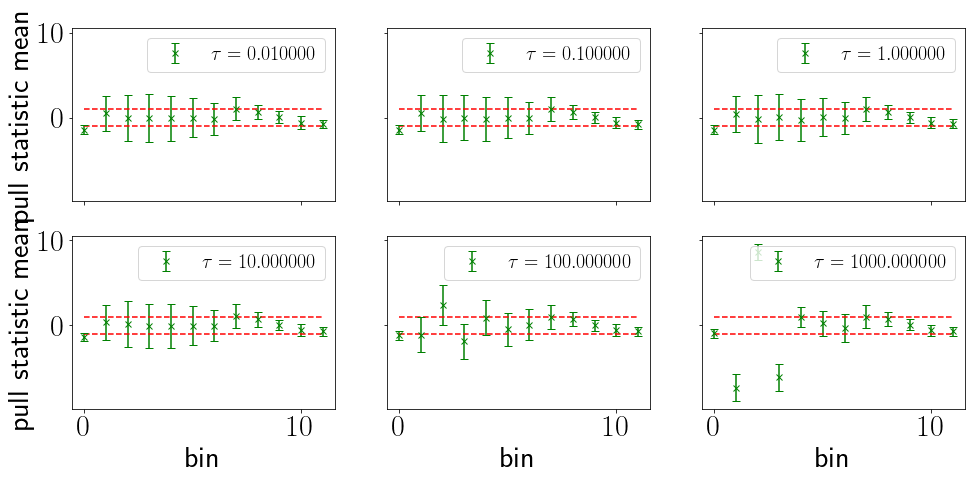

In [14]:
plot_bias(set1)

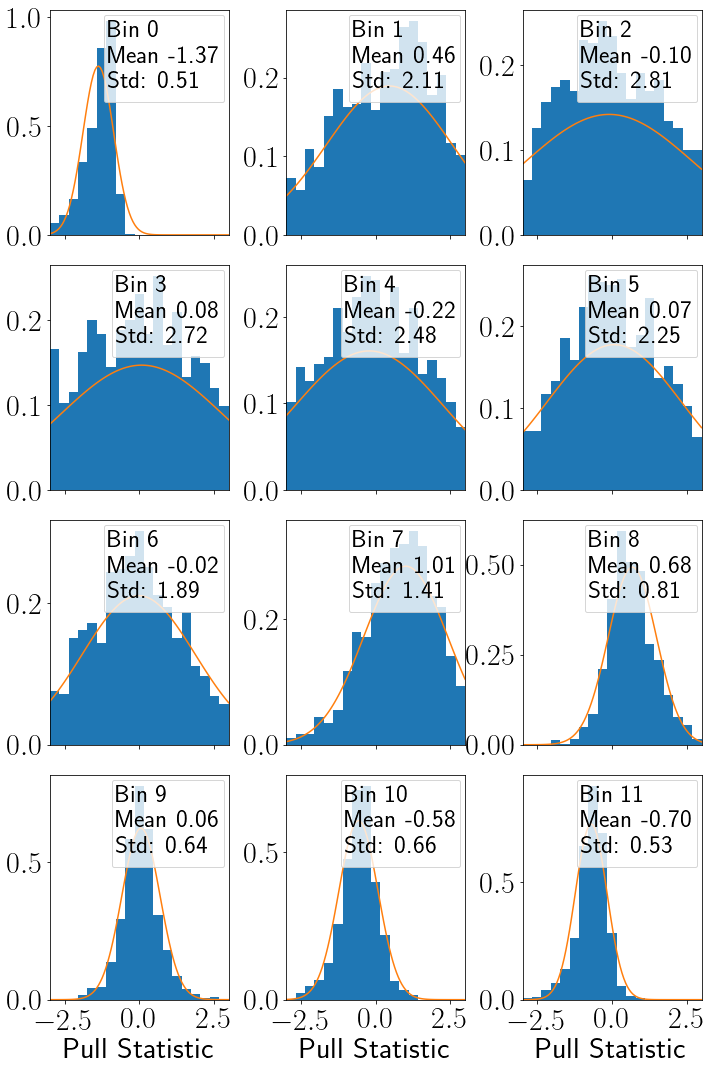

In [15]:
plot_pulls(set1[2])

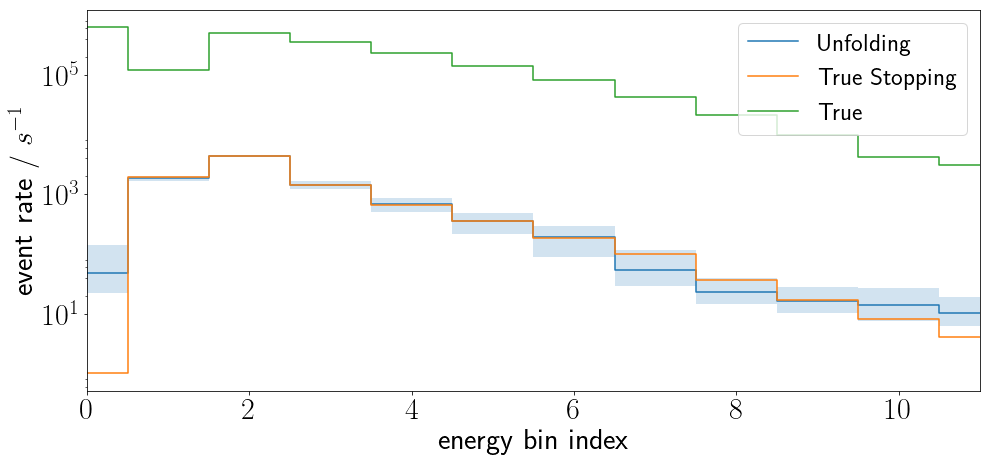

In [16]:
plot_eventSpectrum(set1[2])

(array([-3.1874429 ,  7.68808651]), array([[ 0.05054911, -0.18945457],
       [-0.18945457,  0.72158173]]))


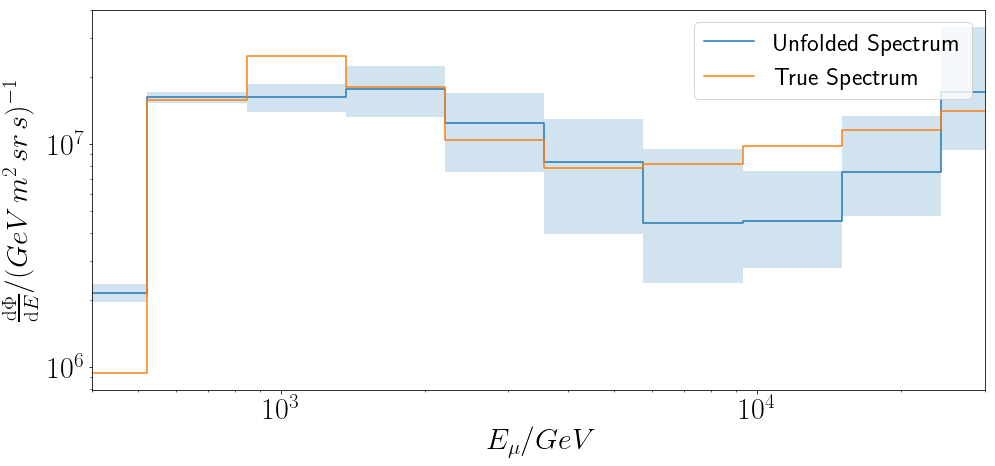

In [17]:
plot_flux(set1[2], fit=True)